# PyTorch实战: CIFAR10图像分类

## 1 任务目标

### 1.1 用多层感知机(MLP)和卷积网络(ConvNet)完成CIFAR10分类

   使用PyTorch分别实现多层感知机(MLP)和卷积网络(ConvNet)，并完成CIFAR10数据集（http://www.cs.toronto.edu/~kriz/cifar.html） 分类。本案例不提供初始代码，请自行配置网络和选取超参数，包括层数、卷积核数目、激活函数类型、损失函数类型、优化器等方面。

   提交所有代码和一份案例报告，要求如下：

- 详细介绍所使用的模型及其结果，至少包括超参数选取，损失函数、准确率及其曲线；

- 比较不同模型配置下的结果，<font color='red'>至少从三个方面</font>作比较和分析，例如层数、卷积核数目、激活函数类型、损失函数类型、优化器等。

### 1.2 学习PyTorch ImageNet分类示例

   请自行学习PyTorch官方提供的ImageNet分类示例代码，以便更好地完成后续案例(https://github.com/pytorch/examples/tree/master/imagenet)，这部分无需提交代码和报告。

### 1.3 注意事项

- 提交所有代码和一份案例报告；

- 禁止任何形式的抄袭。

## 2 代码设计
导入相应库

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### 2.1 初始化及数据预处理
1. 设置设备

In [3]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2. 数据预处理
    
    该部分负责在创建数据集时，对数据进行预处理，具体操作如下：
    - `transforms.ToTensor()`：将图像转换为PyTorch张量。
    - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`：对图像进行标准化，将像素值归一化到均值为0.5，标准差为0.5的范围。

In [4]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

3. 数据集创建

    CIFAR-10 数据集是一个用于图像分类的常用数据集，该数据集包含了10个类别的彩色图像，每个类别有6,000张图像，共计60,000张图像。每张图像的尺寸是32x32像素。

    该部分用于下载CIFAR-10数据集，并按指定预处理操作，创建训练集和测试集。
    - `torchvision.datasets.CIFAR10`: 这是PyTorch中专门用于加载CIFAR-10数据集的类。
    - `root='./data'`: 这指定了数据集将被下载到的本地目录。
    - `train=True`和`train=False`: 当train=True时，表示创建训练集；当train=False时，表示创建测试集。
    - `download=True`: 如果本地没有找到CIFAR-10数据集，设置为True时，PyTorch将自动下载并解压缩数据集。
    - `transform=transform`: 这里的transform参数指定了数据集中图像的预处理操作，即前面提到的transforms.Compose创建的数据预处理管道。

In [5]:
# 下载CIFAR-10数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


4. 创建数据加载器

    创建用于训练和测试的数据加载器（DataLoader）。`train_loader`用于训练，`test_loader`用于测试。
    
    这些数据加载器在训练和测试过程中会循环提供每个批次的图像和标签，方便使用PyTorch的模型进行训练和评估。

    - `torch.utils.data.DataLoader`: 这是PyTorch中的一个类，用于从数据集中加载批量的数据。
    - `batch_size=64`: 这指定了每个批次加载的图像数量。
    - `shuffle=True`和`shuffle=False`: 这表示是否在每个epoch开始时随机打乱数据。在训练集中，通常希望打乱数据以防止模型学到数据的顺序性，而在测试集中则可以保持数据的原始顺序。
    - `num_workers=2`: 这指定了用于加载数据的子进程数量。

In [6]:
# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

5. 显示数据集图片

    将一个批次（64）的数据集图像及标签通过 `Matplotlib` 显示出来。

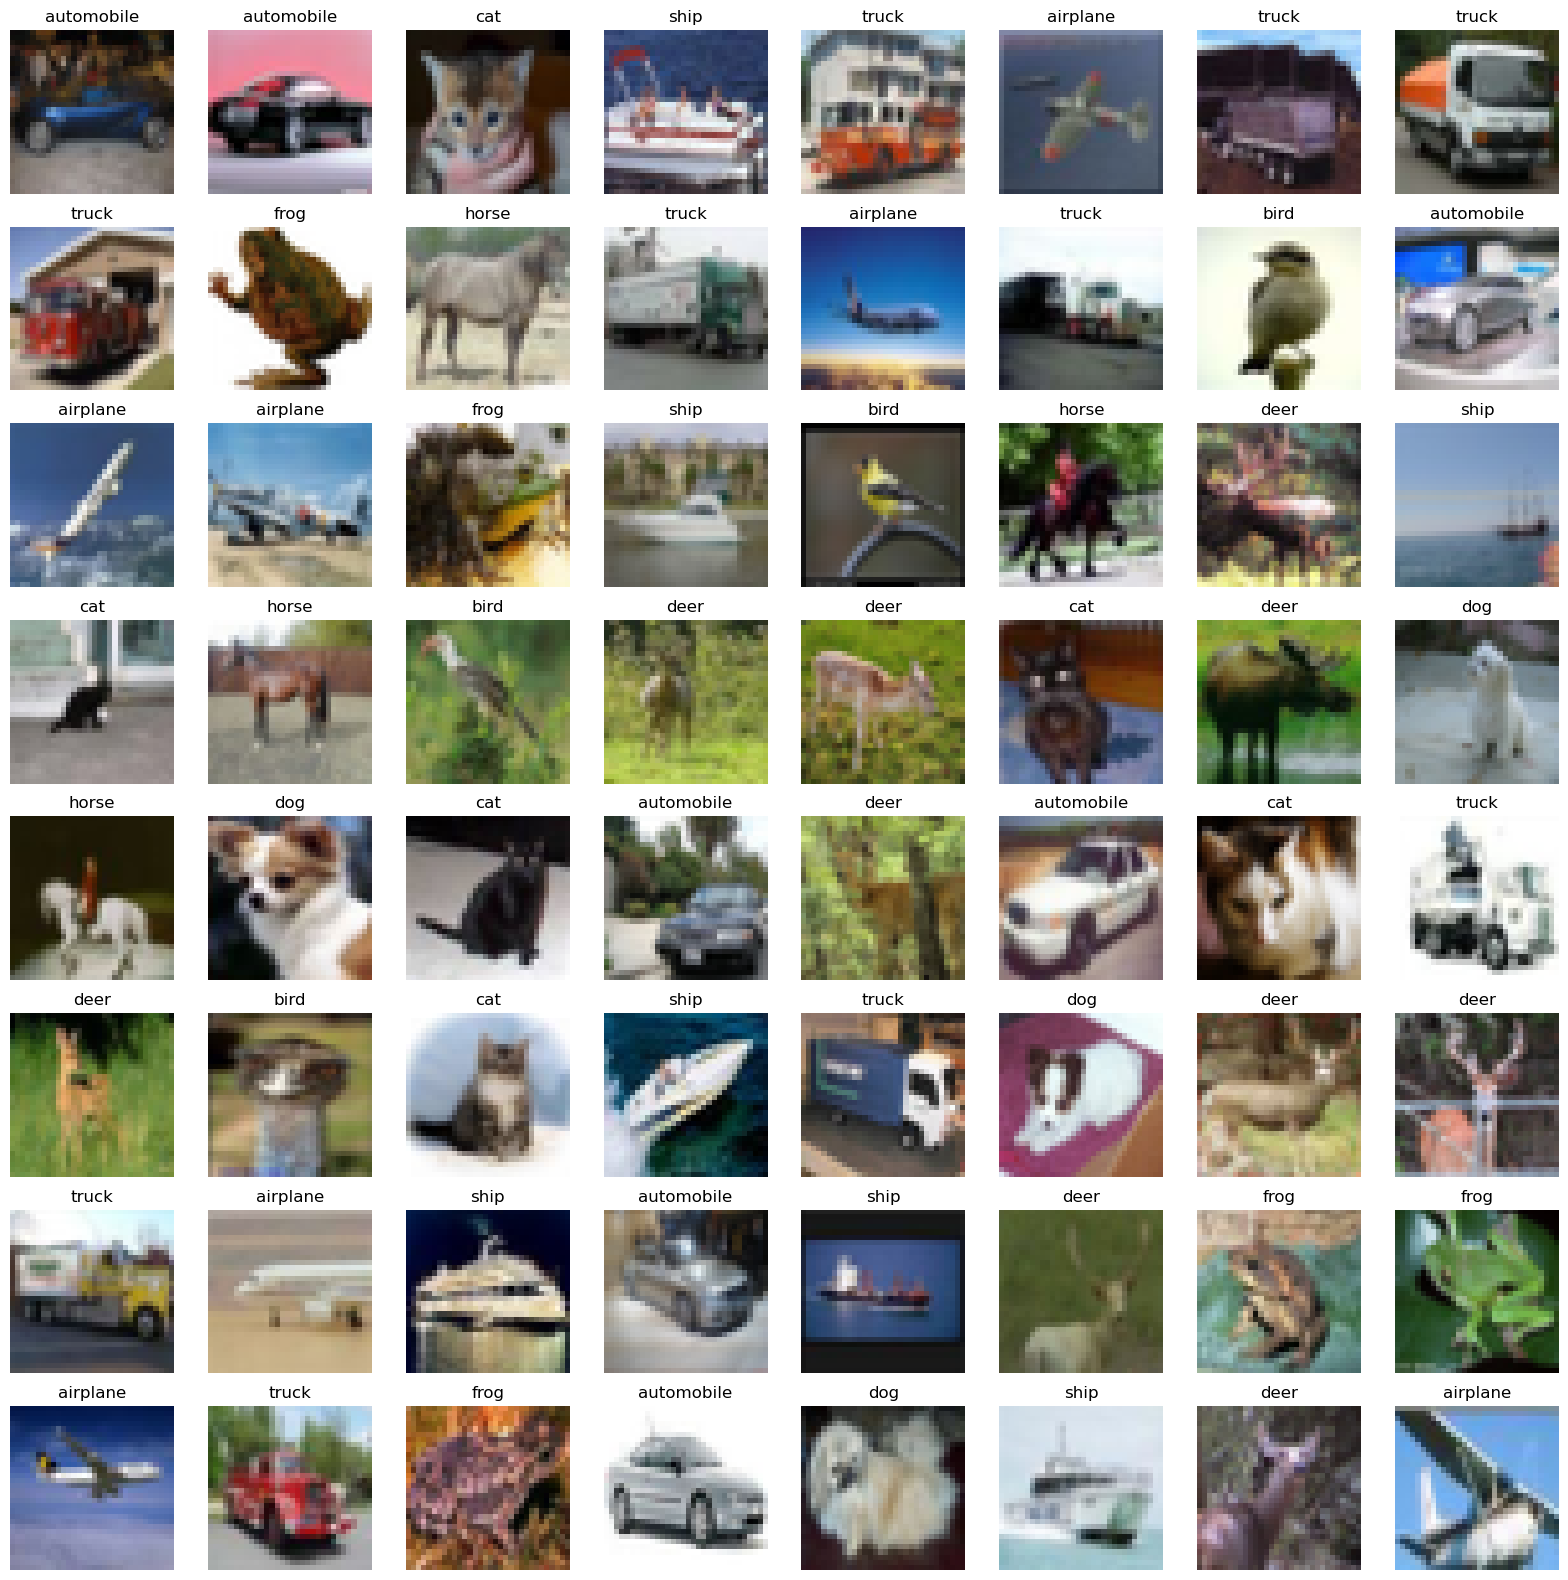

In [13]:
# 获取一个批次的图像和标签
for images, labels in train_loader:
    break  # 获取第一个批次后就跳出循环

# 将张量转换为NumPy数组
images = images.numpy()

# 反归一化
images = (images * 0.5) + 0.5

# 定义标签对应的类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 显示图像和标签
plt.figure(figsize=(20, 20))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()

### 2.2 模型建立
1. 建立MLP模型

    MLP模型由三个全连接层组成，通过ReLU激活函数进行非线性变换，最终输出一个10维的张量，表示对每个类别的预测得分。

In [14]:
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. 建立简单卷积神经网络模型

    这个ConvNet模型包含了两个卷积层和两个全连接层，通过ReLU激活函数进行非线性变换，并通过最大池化进行下采样。

In [ ]:
# 定义ConvNet模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

3. 建立自定义MLP模型
    
    在这个 DefMLP 模型中，可以调整层数`num_layers`,激活函数 `activation_func`。

In [ ]:
class DefMLP(nn.Module):
    def __init__(self, num_layers, activation_func):
        super(DefMLP, self).__init__()

        layers = []
        input_size = 32 * 32 * 3
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, 512))
            input_size = 512  # 更新输入大小
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Invalid activation function")

        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = self.fc(x)
        return x

4. 建立自定义卷积神经网络模型

    在这个 DefConvNet 模型中，可以调整卷积层数`num_layers`、激活函数`activation_func`和卷积核数目`num_channels`。每个卷积层后面都添加了激活函数和最大池化层。



In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_layers, activation_func, num_channels):
        super(ConvNet, self).__init__()

        layers = []
        in_channels = 3
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            in_channels = num_channels
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Invalid activation function")
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_layers = nn.Sequential(*layers)
        self.fc1 = nn.Linear(num_channels * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# 训练函数
def train(model, optimizer, criterion, num_epochs=40):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在测试集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.4735, Train Acc: 0.4667, Test Loss: 1.1954, Test Acc: 0.5722
Epoch 2/20, Train Loss: 1.0069, Train Acc: 0.6466, Test Loss: 0.9588, Test Acc: 0.6588
Epoch 3/20, Train Loss: 0.8012, Train Acc: 0.7183, Test Loss: 0.8656, Test Acc: 0.6993
Epoch 4/20, Train Loss: 0.6387, Train Acc: 0.7779, Test Loss: 0.8186, Test Acc: 0.7218
Epoch 5/20, Train Loss: 0.4821, Train Acc: 0.8340, Test Loss: 0.7768, Test Acc: 0.7393
Epoch 6/20, Train Loss: 0.3348, Train Acc: 0.8853, Test Loss: 0.8037, Test Acc: 0.7457
Epoch 7/20, Train Loss: 0.2045, Train Acc: 0.9310, Test Loss: 0.9639, Test Acc: 0.7477
Epoch 8/20, Train Loss: 0.1184, Train Acc: 0.9610, Test Loss: 1.0306, Test Acc: 0.7506
Epoch 9/20, Train Loss: 0.0629, Train Acc: 0.9809, Test Loss: 1.1930, Test Acc: 0.7430
Epoch 10/20, Train Loss: 0.0456, Train Acc: 0.9865, Test Loss: 1.2137, Test Acc: 0.7503
Epoch 11/20, Train Loss: 0.0352, Train Acc: 0.9898, T

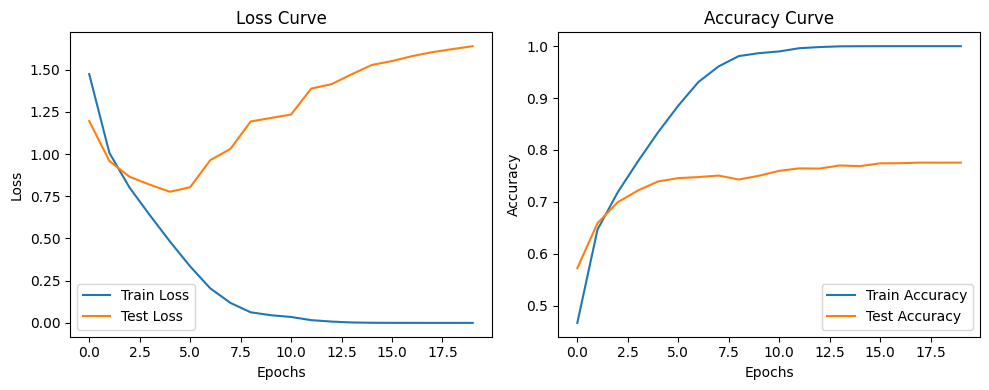

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载CIFAR-10数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 定义ConvNet模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 选择模型（MLP或ConvNet）
# model = MLP().to(device)
model = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制损失和准确率曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title(f'Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title(f'Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# 保存模型
# torch.save(model.state_dict(), 'cifar10_model.pth')


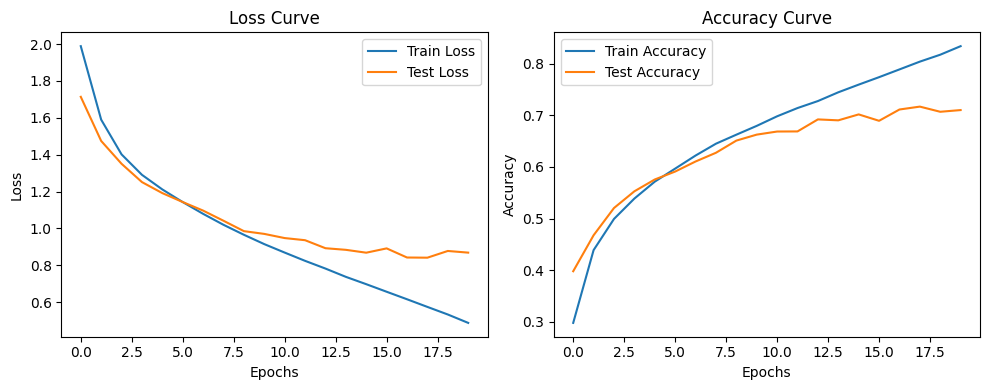

In [6]:
import matplotlib.pyplot as plt
# 绘制损失和准确率曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title(f'Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title(f'Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/40, Train Loss: 1.6379, Train Acc: 0.4163, Test Loss: 1.4929, Test Acc: 0.4715
Epoch 2/40, Train Loss: 1.4320, Train Acc: 0.4961, Test Loss: 1.4139, Test Acc: 0.4943
Epoch 3/40, Train Loss: 1.3141, Train Acc: 0.5373, Test Loss: 1.4057, Test Acc: 0.5049
Epoch 4/40, Train Loss: 1.2165, Train Acc: 0.5691, Test Loss: 1.4035, Test Acc: 0.5037
Epoch 5/40, Train Loss: 1.1334, Train Acc: 0.5959, Test Loss: 1.3744, Test Acc: 0.5268
Epoch 6/40, Train Loss: 1.0451, Train Acc: 0.6293, Test Loss: 1.4091, Test Acc: 0.5313
Epoch 7/40, Train Loss: 0.9686, Train Acc: 0.6548, Test Loss: 1.4320, Test Acc: 0.5386
Epoch 8/40, Train Loss: 0.8900, Train Acc: 0.6837, Test Loss: 1.4587, Test Acc: 0.5375
Epoch 9/40, Train Loss: 0.8151, Train Acc: 0.7094, Test Loss: 1.5576, Test Acc: 0.5310
Epoch 10/40, Train Loss: 0.7380, Train Acc: 0.7385, Test Loss: 1.6559, Test Acc: 0.5300
Epoch 11/40, Train Loss: 0.6795, Train Acc: 0.7603, T

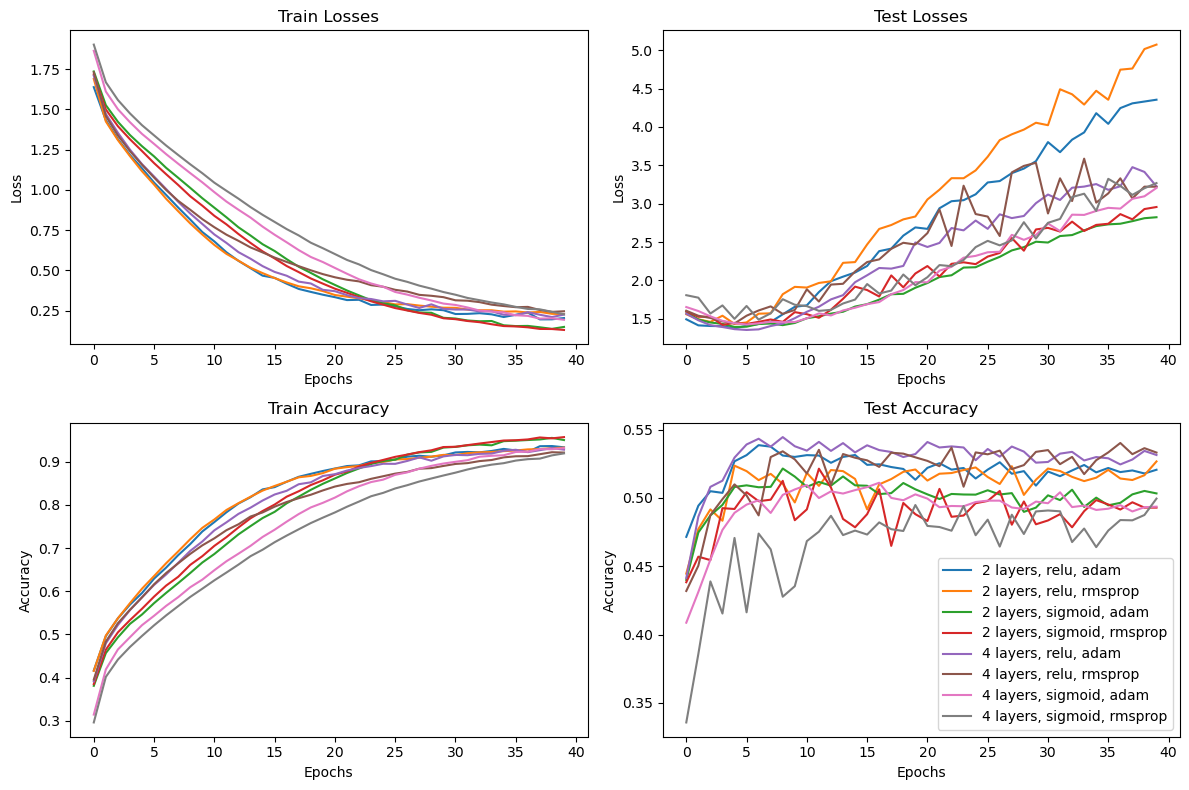

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 数据预处理和加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 定义模型
class CustomNet(nn.Module):
    def __init__(self, num_layers, activation_func):
        super(CustomNet, self).__init__()

        layers = []
        input_size = 32 * 32 * 3
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, 512))
            input_size = 512  # 更新输入大小
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Invalid activation function")

        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = self.fc(x)
        return x


# 训练函数
def train(model, optimizer, criterion, num_epochs=40):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在测试集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies

# 实验不同配置
configs = [
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
]


# 训练并绘制曲线
plt.figure(figsize=(12, 8))

for config in configs:
    model = CustomNet(num_layers=config['num_layers'], activation_func=config['activation_func']).to(device)
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif config['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    else:
        raise ValueError("Invalid optimizer")

    train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion)

    # 训练集的损失和准确率
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


    # 测试集的损失和准确率
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # 训练集的准确率
    plt.subplot(2, 2, 3)
    plt.plot(train_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # 测试集的准确率
    plt.subplot(2, 2, 4)
    plt.plot(test_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()